In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image

import json
import time
import math
import os

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

In [12]:
google_flowers = False
class_name_file = './data/class_indices.json'
train_data_path = "/media/stree/localssd/DL_data/flower_data2/train"
val_data_path = "/media/stree/localssd/DL_data/flower_data2/val"
test_data_path = "/media/stree/localssd/DL_data/flower_data2/val/"

if not google_flowers:
    class_name_file = './data/flowers_17_cat_to_name.json'
    train_data_path = "/media/stree/localssd/DL_data/flower_17/train"
    val_data_path = "/media/stree/localssd/DL_data/flower_17/val"
    test_data_path = "/media/stree/localssd/DL_data/flower_17/test/"
    
def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

with open(class_name_file, 'r') as f:
    cat_to_name = json.load(f)
    
print(cat_to_name)
print(cat_to_name['1'])
print(cat_to_name['4'])
print()
classes, c_2_idx = find_classes(train_data_path)
print(classes)
print(c_2_idx)
print()
cls_2_name = {}

print(c_2_idx.keys())
print()
for k in c_2_idx.keys():
    cls = c_2_idx[str(k)]
    print('k: ', k, ' cls: ', cls)
    if google_flowers:
        cls_2_name[str(cls)] = cat_to_name[str(cls)]
    else:
        cls_2_name[int(cls)] = cat_to_name[str(k)]
print(cls_2_name)

{'1': 'pink primrose', '2': 'hard-leaved pocket orchid', '3': 'canterbury bells', '4': 'sweet pea', '5': 'english marigold', '6': 'tiger lily', '7': 'moon orchid', '8': 'bird of paradise', '9': 'monkshood', '10': 'globe thistle', '11': 'snapdragon', '12': "colt's foot", '13': 'king protea', '14': 'spear thistle', '15': 'yellow iris', '16': 'globe-flower', '17': 'purple coneflower'}
pink primrose
sweet pea

['1', '10', '11', '12', '13', '14', '15', '16', '17', '2', '3', '4', '5', '6', '7', '8', '9']
{'1': 0, '10': 1, '11': 2, '12': 3, '13': 4, '14': 5, '15': 6, '16': 7, '17': 8, '2': 9, '3': 10, '4': 11, '5': 12, '6': 13, '7': 14, '8': 15, '9': 16}

dict_keys(['1', '10', '11', '12', '13', '14', '15', '16', '17', '2', '3', '4', '5', '6', '7', '8', '9'])

k:  1  cls:  0
k:  10  cls:  1
k:  11  cls:  2
k:  12  cls:  3
k:  13  cls:  4
k:  14  cls:  5
k:  15  cls:  6
k:  16  cls:  7
k:  17  cls:  8
k:  2  cls:  9
k:  3  cls:  10
k:  4  cls:  11
k:  5  cls:  12
k:  6  cls:  13
k:  7  cls:  14

In [13]:

# Note transforms.ToTensor() scales input images
# to 0-1 range
data_transform = {
        "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        "val": transforms.Compose([transforms.Resize(256),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}
    
train_data = torchvision.datasets.ImageFolder(root=train_data_path,
                                              transform=data_transform['train'])

val_data = torchvision.datasets.ImageFolder(root=val_data_path,
                                            transform=data_transform['val'])

batch_size=16

nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 4])  # number of workers
print('Using {} dataloader workers every process'.format(nw))
    
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True,
                                               num_workers=nw)
val_data_loader  = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False,
                                              num_workers=nw)

device = torch.device("cpu")
use_gpu = False
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    device = torch.device("cuda:0")
    use_gpu = True
        
print(device)
print(('load data ---> done!'))

Using 4 dataloader workers every process
cuda:0
load data ---> done!


In [14]:

import numpy as np
print(train_data[12][0].shape)
# ---- train_data in tuples
n = 1 
labels = [x[n] for x in train_data]
#print(labels)
print(np.unique(labels))          
num_classes = len(np.unique(labels))

print(num_classes)


torch.Size([3, 224, 224])
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
17


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])
tensor([ 0,  7,  9,  1,  7,  3,  5,  5,  9,  7,  0,  7,  7, 16, 12, 12])


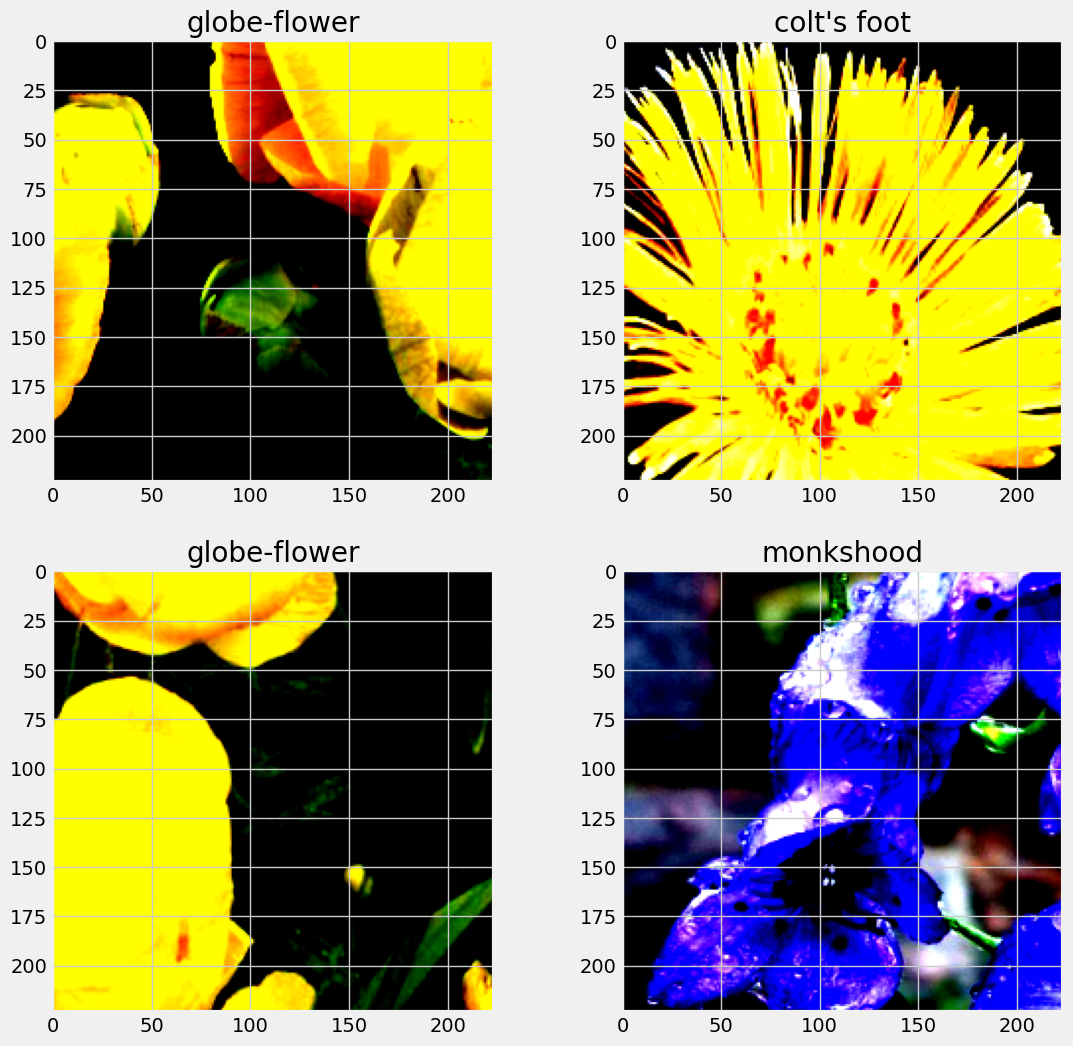

In [15]:
it = iter(train_data_loader)

dt,target = it.__next__()
print(dt[1].shape)
print(target)

# 显示图片
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(12,12))
if google_flowers:
    axes[0,0].imshow(dt[1].numpy().transpose(1, 2, 0)) # change (3, 224, 224) => (224, 224, 3)
    axes[0,0].title.set_text(cls_2_name[str(target[1].numpy())])
    axes[0,1].imshow(dt[5].numpy().transpose(1, 2, 0))
    axes[0,1].title.set_text(cls_2_name[str(target[5].numpy())])
    axes[1,0].imshow(dt[9].numpy().transpose(1, 2, 0))
    axes[1,0].title.set_text(cls_2_name[str(target[9].numpy())])
    axes[1,1].imshow(dt[13].numpy().transpose(1, 2, 0))
    axes[1,1].title.set_text(cls_2_name[str(target[13].numpy())])
else:
    axes[0,0].imshow(dt[1].numpy().transpose(1, 2, 0)) # change (3, 224, 224) => (224, 224, 3)
    axes[0,0].title.set_text(cls_2_name[int(target[1].numpy())])
    axes[0,1].imshow(dt[5].numpy().transpose(1, 2, 0))
    axes[0,1].title.set_text(cls_2_name[int(target[5].numpy())])
    axes[1,0].imshow(dt[9].numpy().transpose(1, 2, 0))
    axes[1,0].title.set_text(cls_2_name[int(target[9].numpy())])
    axes[1,1].imshow(dt[13].numpy().transpose(1, 2, 0))
    axes[1,1].title.set_text(cls_2_name[int(target[13].numpy())])
plt.show()

In [16]:
################################
# network EfficientNet
################################
def swish(x):
    return x * x.sigmoid()


def drop_connect(x, drop_ratio):
    keep_ratio = 1.0 - drop_ratio
    mask = torch.empty([x.shape[0], 1, 1, 1], dtype=x.dtype, device=x.device)
    mask.bernoulli_(keep_ratio)
    x.div_(keep_ratio)
    x.mul_(mask)
    return x


class SE(nn.Module):
    '''Squeeze-and-Excitation block with Swish.'''

    def __init__(self, in_planes, se_planes):
        super(SE, self).__init__()
        self.se1 = nn.Conv2d(in_planes, se_planes, kernel_size=1, bias=True)
        self.se2 = nn.Conv2d(se_planes, in_planes, kernel_size=1, bias=True)

    def forward(self, x):
        out = F.adaptive_avg_pool2d(x, (1, 1))
        out = swish(self.se1(out))
        out = self.se2(out).sigmoid()
        out = x * out
        return out


class Block(nn.Module):
    '''expansion + depthwise + pointwise + squeeze-excitation'''

    def __init__(self,
                 in_planes,
                 out_planes,
                 kernel_size,
                 stride,
                 expand_ratio=1,
                 se_ratio=0.,
                 drop_rate=0.):
        super(Block, self).__init__()
        self.stride = stride
        self.drop_rate = drop_rate
        self.expand_ratio = expand_ratio

        # Expansion
        planes = expand_ratio * in_planes
        self.conv1 = nn.Conv2d(in_planes,
                               planes,
                               kernel_size=1,
                               stride=1,
                               padding=0,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        # Depthwise conv
        self.conv2 = nn.Conv2d(planes,
                               planes,
                               kernel_size=kernel_size,
                               stride=stride,
                               padding=(1 if kernel_size == 3 else 2),
                               groups=planes,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        # SE layers
        se_planes = int(in_planes * se_ratio)
        self.se = SE(planes, se_planes)

        # Output
        self.conv3 = nn.Conv2d(planes,
                               out_planes,
                               kernel_size=1,
                               stride=1,
                               padding=0,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(out_planes)

        # Skip connection if in and out shapes are the same (MV-V2 style)
        self.has_skip = (stride == 1) and (in_planes == out_planes)

    def forward(self, x):
        out = x if self.expand_ratio == 1 else swish(self.bn1(self.conv1(x)))
        out = swish(self.bn2(self.conv2(out)))
        out = self.se(out)
        out = self.bn3(self.conv3(out))
        if self.has_skip:
            if self.training and self.drop_rate > 0:
                out = drop_connect(out, self.drop_rate)
            out = out + x
        return out


class EfficientNet(nn.Module):
    def __init__(self, cfg, num_classes=10):
        super(EfficientNet, self).__init__()
        self.cfg = cfg
        self.conv1 = nn.Conv2d(3,
                               32,
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32)
        self.linear = nn.Linear(cfg['out_planes'][-1], num_classes)

    def _make_layers(self, in_planes):
        layers = []
        cfg = [self.cfg[k] for k in ['expansion', 'out_planes', 'num_blocks', 'kernel_size',
                                     'stride']]
        for expansion, out_planes, num_blocks, kernel_size, stride in zip(*cfg):
            strides = [stride] + [1] * (num_blocks - 1)
            for stride in strides:
                layers.append(
                    Block(in_planes,
                          out_planes,
                          kernel_size,
                          stride,
                          expansion,
                          se_ratio=0.25,
                          drop_rate=0))
                in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = swish(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def EfficientNetB0(num_classes):
    cfg = {
        'num_blocks': [1, 2, 2, 3, 3, 4, 1],
        'expansion': [1, 6, 6, 6, 6, 6, 6],
#        'out_planes': [16, 24, 40, 80, 112, 192, 320],
        'out_planes': [4, 6, 10, 20, 28, 48, 80],
        'kernel_size': [3, 3, 5, 3, 5, 5, 3],
        'stride': [1, 2, 2, 2, 1, 2, 1],
    }
    return EfficientNet(cfg, num_classes)

model = EfficientNetB0(num_classes)
#print(model)

input = torch.randn(8,3,224,224)
out = model(input)
print(out.shape)


torch.Size([8, 17])


In [17]:
model = EfficientNetB0(num_classes)
#print(model)

input = torch.randn(8,3,224,224)
out = model(input)
print(out.shape)

torch.Size([8, 17])


In [18]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=10, device="cpu"):

    for epoch in range(epochs):
        if use_gpu:
            #print(torch.cuda.memory_summary())
            torch.cuda.empty_cache()
            
        # print('---- Training ----')
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        # print('---- Validating ----')
        model.eval()
        num_correct = 0 
        num_examples = 0
        with torch.no_grad(): 
            for batch in val_loader:
                inputs, targets = batch
                inputs = inputs.to(device)
                output = model(inputs)
                targets = targets.to(device)
                loss = loss_fn(output,targets) 
                valid_loss += loss.data.item() * inputs.size(0)
                correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
                num_correct += torch.sum(correct).item()
                num_examples += correct.shape[0]
            valid_loss /= len(val_loader.dataset)

        print('Epoch: {:3d},  Training Loss: {:.4f}, Validation Loss: {:.4f}, accuracy = {:.2f}'.format(
            epoch + 1, training_loss, valid_loss, num_correct / num_examples))

In [19]:
model.to(device)
#optimizer = optim.Adam(model.parameters(), lr=0.001)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(params, lr=0.001)

### Training model

In [20]:
# Training model

train(model, optimizer,torch.nn.CrossEntropyLoss(), train_data_loader,
      val_data_loader, epochs=50, device=device)

Epoch:   1,  Training Loss: 2.8156, Validation Loss: 2.8394, accuracy = 0.06
Epoch:   2,  Training Loss: 2.6769, Validation Loss: 2.8731, accuracy = 0.06
Epoch:   3,  Training Loss: 2.5393, Validation Loss: 3.0878, accuracy = 0.06
Epoch:   4,  Training Loss: 2.4504, Validation Loss: 2.7907, accuracy = 0.12
Epoch:   5,  Training Loss: 2.3187, Validation Loss: 2.4412, accuracy = 0.18
Epoch:   6,  Training Loss: 2.2256, Validation Loss: 2.2656, accuracy = 0.23
Epoch:   7,  Training Loss: 2.0904, Validation Loss: 2.3010, accuracy = 0.17
Epoch:   8,  Training Loss: 2.0238, Validation Loss: 2.0832, accuracy = 0.35
Epoch:   9,  Training Loss: 2.0541, Validation Loss: 2.1442, accuracy = 0.32
Epoch:  10,  Training Loss: 1.9609, Validation Loss: 3.0401, accuracy = 0.30
Epoch:  11,  Training Loss: 2.0218, Validation Loss: 1.8856, accuracy = 0.37
Epoch:  12,  Training Loss: 1.8384, Validation Loss: 1.8718, accuracy = 0.33
Epoch:  13,  Training Loss: 1.8504, Validation Loss: 1.6372, accuracy = 0.47

### Test

In [21]:
test_data = torchvision.datasets.ImageFolder(root=test_data_path,transform=data_transform['val'])

batch_size=16
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          shuffle=False, num_workers=nw)

loss_fn = torch.nn.CrossEntropyLoss()

model.eval()
num_correct = 0 
num_examples = 0
test_loss = 0.0

with torch.no_grad():
    for batch in test_loader:
        inputs, targets = batch
        inputs = inputs.to(device)
        output = model(inputs)
        targets = targets.to(device)
        loss = loss_fn(output,targets) 
        test_loss += loss.data.item() * inputs.size(0)
        correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
        num_correct += torch.sum(correct).item()
        num_examples += correct.shape[0]
    test_loss /= len(test_loader.dataset)

print('Test Loss: {:.4f}, accuracy = {:.2f}'.format(test_loss, num_correct / num_examples))

Test Loss: 1.0358, accuracy = 0.69


tensor([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([ 0,  0, 10,  0, 16,  1,  1,  1,  1,  1,  1,  1,  5,  5, 16,  5],
       device='cuda:0')
(3, 224, 224)
(3, 1, 1)


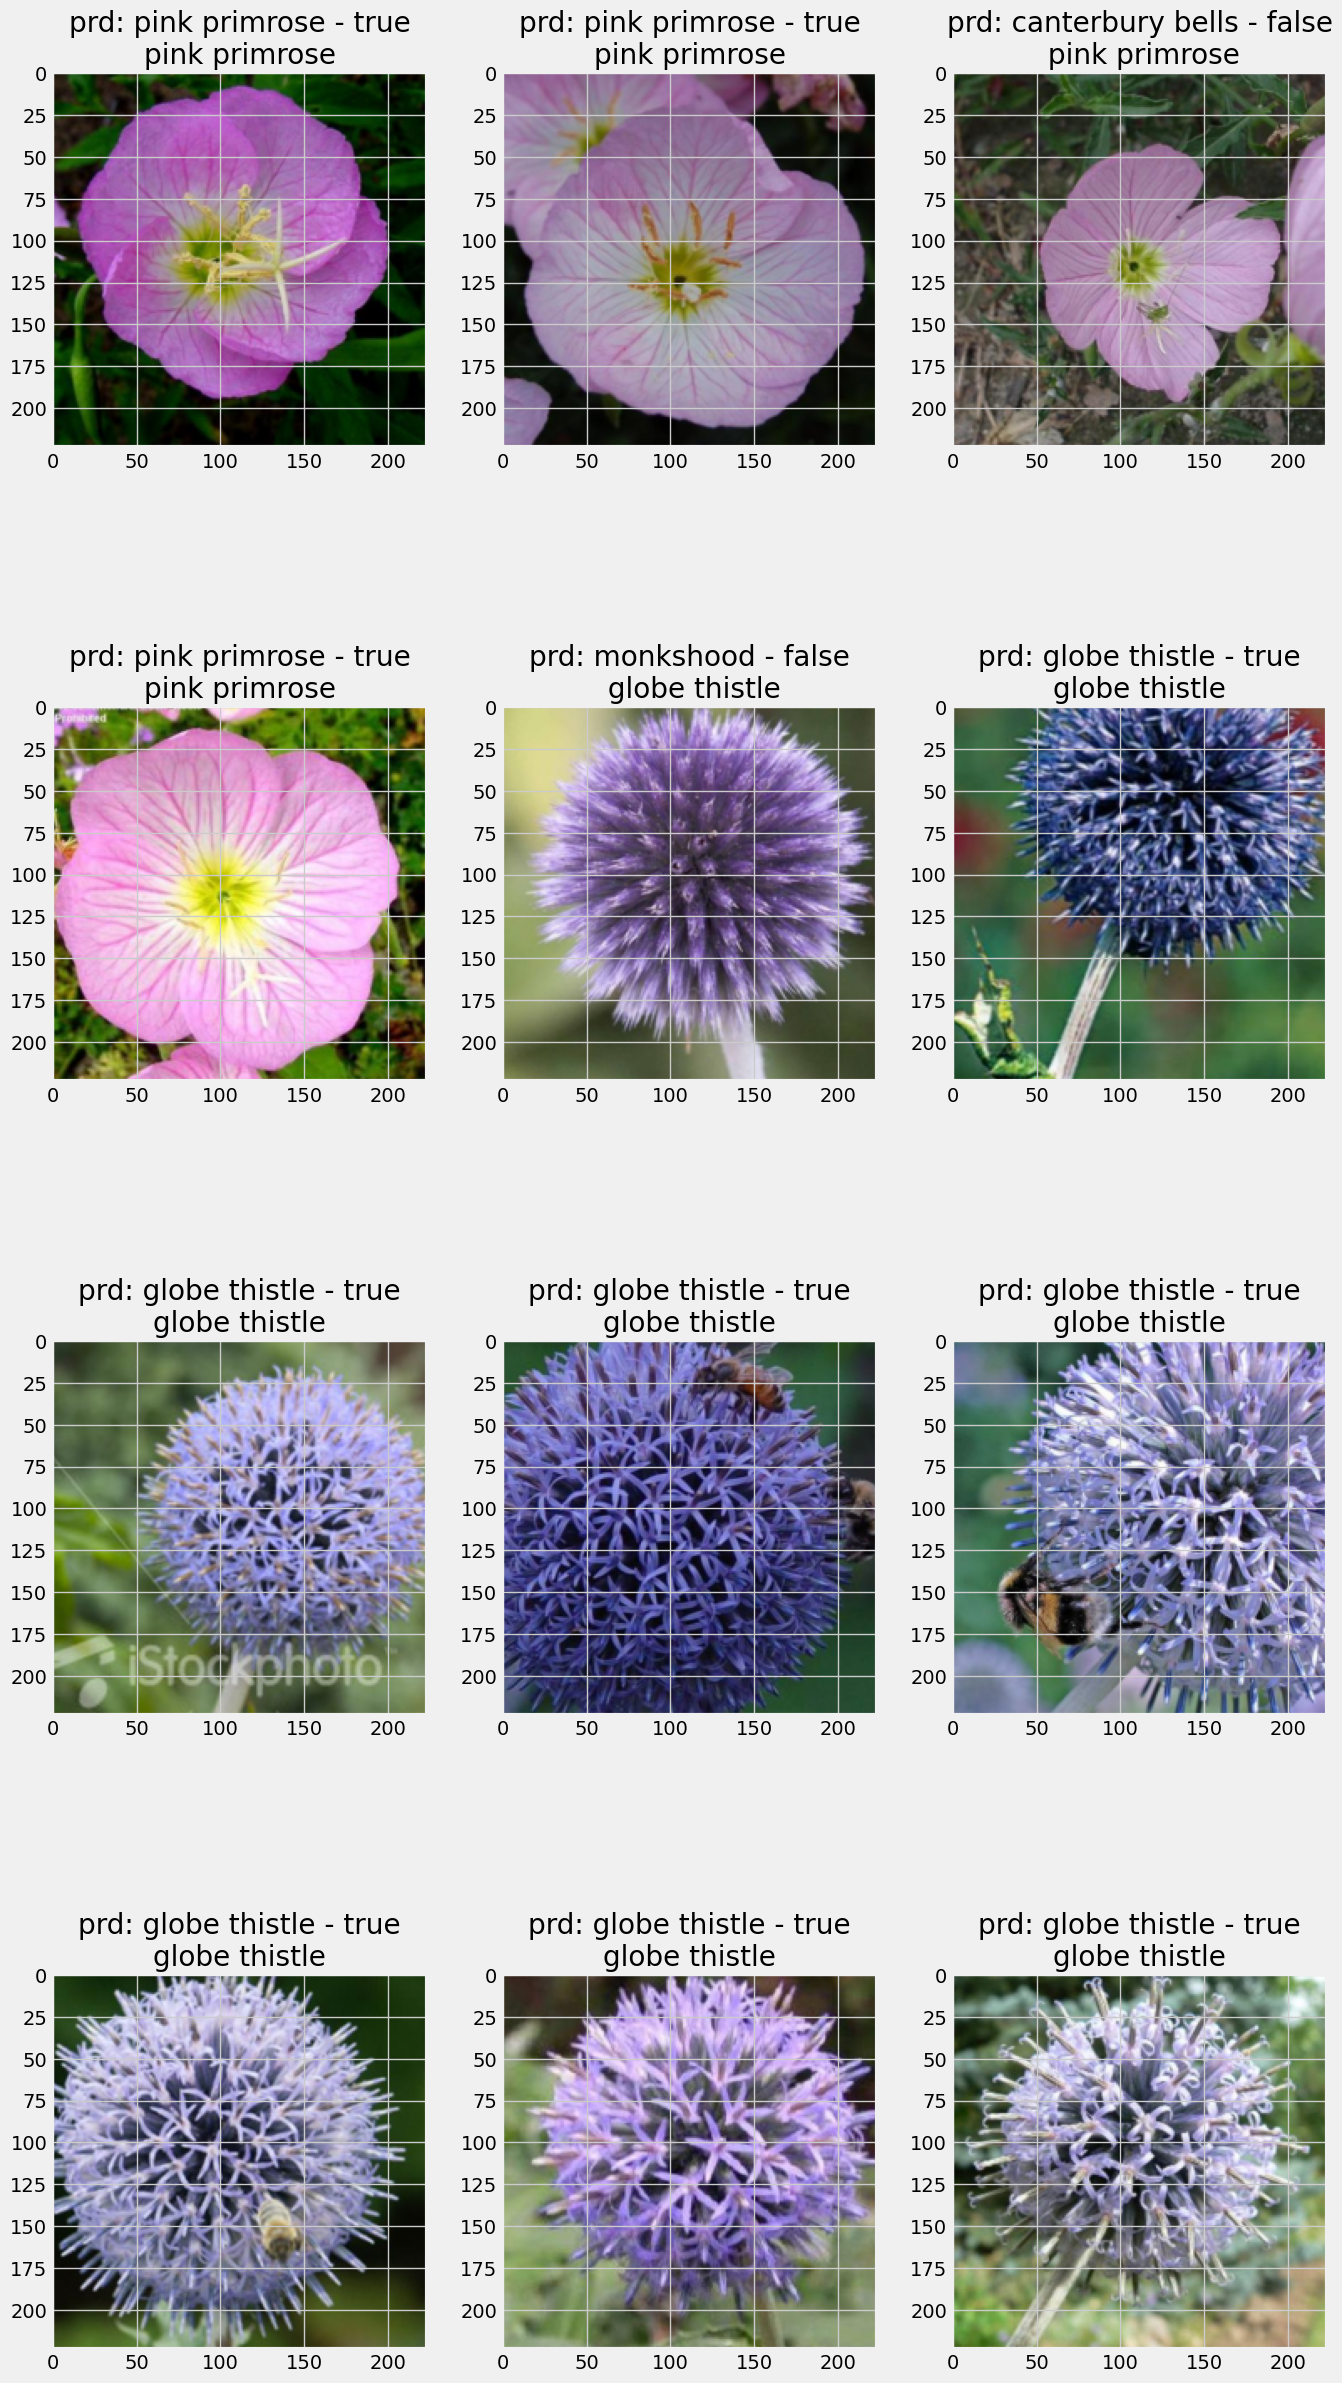

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    2389 MB |    2516 MB |   16577 GB |   16575 GB |
|       from large pool |    2372 MB |    2500 MB |   16506 GB |   16503 GB |
|       from small pool |      17 MB |      18 MB |      71 GB |      71 GB |
|---------------------------------------------------------------------------|
| Active memory         |    2389 MB |    2516 MB |   16577 GB |   16575 GB |
|       from large pool |    2372 MB |    2500 MB |   16506 GB |

In [22]:
it = iter(test_loader)
it.__next__()
dt, labs = it.__next__()
dt = dt.to(device)
output = model(dt)
prd_labs = torch.max(F.softmax(output), dim=1)[1].view(-1)
print(labs)
print(prd_labs)

img_mean = torch.tensor([0.485, 0.456, 0.406]).reshape((3, 1, 1)).to(device)
img_std = torch.tensor([0.229, 0.224, 0.225]).reshape((3, 1, 1)).to(device)
print(dt[0].cpu().numpy().shape)
print(img_mean.cpu().numpy().shape)

plt.figure(figsize=(25,30))
row = 4
col = 3
if google_flowers:
    row = 3
    col = 4
    plt.figure(figsize=(16,15))
    
k = 0
for i in range(row):
    for j in range(col):
        if google_flowers:
            ax = plt.subplot2grid((3,4), (i,j))
        else:
            ax = plt.subplot2grid((4,5), (i,j)) 
        
        # -----------------------------------------------------------------------------------------------------------------
        # tensor denormalization
        # -----------------------------------------------------------------------------------------------------------------
        img_dt = torch.mul(dt[k], img_std) + img_mean
        img_dt = img_dt*255
        img_dt = img_dt.to(torch.uint8)
        
        if use_gpu:
            img_dt = img_dt.cpu().numpy().transpose((1, 2, 0))
            if google_flowers:
                if int(prd_labs[k].cpu().numpy()) == int(labs[k].numpy()):
                    tlt = 'prd: ' + cls_2_name[str(prd_labs[k].cpu().numpy())] + ' - true\n' + cls_2_name[str(labs[k].numpy())]
                    ax.imshow(img_dt)
                else:
                    tlt = 'prd: ' + cls_2_name[str(prd_labs[k].cpu().numpy())] + ' - false\n' + cls_2_name[str(labs[k].numpy())]
                    ax.imshow(img_dt)
            else:
                if int(prd_labs[k].cpu().numpy()) == int(labs[k].numpy()):
                    tlt = 'prd: ' + cls_2_name[int(prd_labs[k].cpu().numpy())] + ' - true\n' + cls_2_name[int(labs[k].numpy())]
                    ax.imshow(img_dt)
                else:
                    tlt = 'prd: ' + cls_2_name[int(prd_labs[k].cpu().numpy())] + ' - false\n ' + cls_2_name[int(labs[k].numpy())]
                    ax.imshow(img_dt)
        else:
            img_dt = img_dt.numpy().transpose((1, 2, 0))
            if google_flowers:
                if int(prd_labs[k].numpy()) == int(labs[k].numpy()):
                    tlt = 'prd: ' + cls_2_name[str(prd_labs[k].numpy())] + ' - true\n ' + cls_2_name[str(labs[k].numpy())]
                    ax.imshow(img_dt)
                else:
                    tlt = 'prd: ' + cls_2_name[str(prd_labs[k].numpy())] + ' - false\n' + cls_2_name[str(labs[k].numpy())]
                    ax.imshow(img_dt)
            else:
                if int(prd_labs[k].numpy()) == int(labs[k].numpy()):
                    tlt = 'prd: ' + cls_2_name[int(prd_labs[k].numpy())] + ' - true\n' + cls_2_name[int(labs[k].numpy())]
                    ax.imshow(img_dt)
                else:
                    tlt = 'prd: ' + cls_2_name[int(prd_labs[k].numpy())] + ' - false\n' + cls_2_name[int(labs[k].numpy())]
                    ax.imshow(img_dt)
        ax.title.set_text(tlt)
        #ax.scatter(range(20),range(20)+np.random.randint(-5,5,20))
        k = k + 1
plt.show()

if use_gpu:
    torch.cuda.empty_cache()
    print(torch.cuda.memory_summary())
            